In [2]:
import shortuuid
from PIL import Image
import json
import os
import random
import matplotlib.pyplot as plt

In [3]:
# utility functions
from torch.utils.data import Dataset
class MulticlassGenImage(Dataset):
    def __init__(self, img_dir, val_gt=None, transform=None):
        self.transform = transform
        self.img_dir = img_dir
        self.img_labels = []
        self.img_paths = []
        with os.scandir(img_dir) as entries:
            directories = [entry.name for entry in entries if entry.is_dir()]
            for g, generator in enumerate(sorted(directories, key=lambda entry: entry.lower())):
                split = 'train'
                if val_gt:
                    split = 'val'
                for b, true_or_fake in enumerate(['nature', 'ai']):
                    gen_label = g + 1
                    if b == 0:
                        gen_label = 0
                    image_files = os.listdir(os.path.join(img_dir, generator, split, true_or_fake))
                    image_files = sorted(image_files, key=lambda entry: entry.lower())

                    mc_label = 0
                    previous_class = None
                    for image_name in image_files:
                        name_parts = image_name.split('_')
                        if b == 1:
                            mc_label = int(name_parts[0])
                        else:
                            if name_parts[0] != 'ILSVRC2012':
                                if previous_class:
                                    current_class = name_parts[0]
                                    if previous_class != current_class:
                                        previous_class = current_class
                                        mc_label += 1
                                else:
                                    previous_class = name_parts[0]
                            else: 
                                if val_gt:
                                    mc_label = val_gt[int(name_parts[-1].split('.')[0])]
                        self.img_labels.append({'multiclass' : mc_label, 'generator': gen_label})
                        self.img_paths.append(os.path.join(generator, split, true_or_fake, image_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    

def val_mapping(path):
    with open(os.path.join(path, 'imagenet_class_index.json'), 'r') as file:
        data = json.load(file)
        json_class_index = {value[0]:key for key, value in data.items()}

    mapping = {}
    with open(os.path.join(path, 'ILSVRC2012_mapping.txt'), 'r') as file:
        for line in file.readlines():
            try:
                mapping[line.strip().split(' ')[0]] = json_class_index[line.strip().split(' ')[-1]]
            except:
                break

    with open(os.path.join(path, 'ILSVRC2012_validation_ground_truth.txt'), 'r') as file:
        val_ground_truth = [None] + [int(mapping[line.strip()]) for line in file.readlines()]

    return val_ground_truth

    
def get_image(dataset, multiclass_labels_map, generator_labels_map, index=None, object_category=None, generator=None):
    img_found = False
    i = index
    while not img_found:
        # Index check
        if not i:
            i = random.randint(0, len(dataset) - 1)
        image, label = dataset[i]
        # Object category check
        c = False
        if object_category == label['multiclass'] or object_category is None:
            c = True
        # Generator check
        g = False
        if generator == label['generator'] or generator is None:
            g = True
        if c and g:
            index = i
            img_found = True
        i = None

    # Display the image
    print(str(index) + ": " + dataset.img_paths[index])
    print(f"{multiclass_labels_map[label['multiclass']]}; {generator_labels_map[label['generator']]}")
    plt.imshow(image)  
    plt.title(f"{label}")
    plt.axis('off')
    plt.show()

    return dataset.img_paths[index]

In [4]:
dataset_path = '/home/scardovi/genimage256'
output_path = "/home/scardovi/ai-generated-image-detection/llm/data/eval/custom-vqa/true-false"
json_file_name = "vqa_true_false_benchmark.json"
image_path = "/home/scardovi/genimage256"

with open(os.path.join(dataset_path, 'imagenet_classes.txt'), 'r') as file:
    labels = [line.strip() for line in file.readlines()]
multiclass_labels_map = {index: label for index, label in enumerate(labels)}
generator_labels_list = ["natural"] + [item for item in sorted(os.listdir(dataset_path), key=lambda entry: entry.lower()) if os.path.isdir(os.path.join(dataset_path, item))]
generator_labels_map = {index: word for index, word in enumerate(generator_labels_list)}
# training
ground_truth = val_mapping(dataset_path)
dataset = MulticlassGenImage(img_dir=dataset_path, val_gt=ground_truth)

18778: big_gan/val/ai/129_biggan_00127.JPEG
spoonbill; big_gan


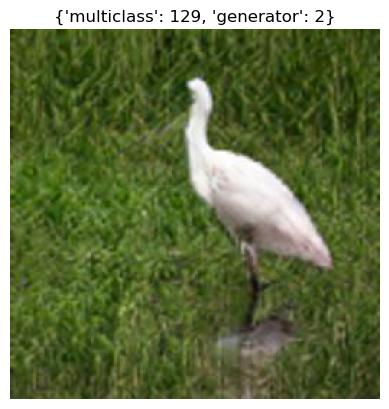

In [25]:
# default: index=None, object_category=None, generator=None
generator=2
image_name = get_image(dataset, multiclass_labels_map, generator_labels_map, generator=generator)

In [418]:
#image_name = "vqdm/val/nature/ILSVRC2012_val_00009258.JPEG"
question = "Is this image real or artificially generated? Just answer with Real or Fake."
gt = "Fake"
answer  = ""
object_category = "brushes"
generator = generator_labels_map[generator]


with open(os.path.join(output_path, json_file_name), 'r') as file:
    try:
        data = json.load(file)
    except:
        data = []

sample_dict = dict()
sample_dict['id'] = shortuuid.uuid()
sample_dict['image'] = os.path.join(output_path, sample_dict['id'] + '.jpg')
image = Image.open(os.path.join(image_path, image_name))
image.save(sample_dict['image'])
sample_dict['question'] = question
sample_dict['ground_truth'] = gt
sample_dict['answer'] = answer
sample_dict['metadata'] = {
    #"object_category": object_category,
    "generator": generator
}

# Add the new item to the existing JSON data 
data.append(sample_dict)

with open(os.path.join(output_path, json_file_name), 'w') as file:
    json.dump(data, file, indent=4)

print(f"Saved {image_name}")

Saved wukong/val/ai/489_wukong_image61.JPEG
